In [40]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LinearRegression

In [41]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

## Look at <span style="color:darkred">Sales Prices</span> 💵

In [42]:
y = data.SalePrice.copy()

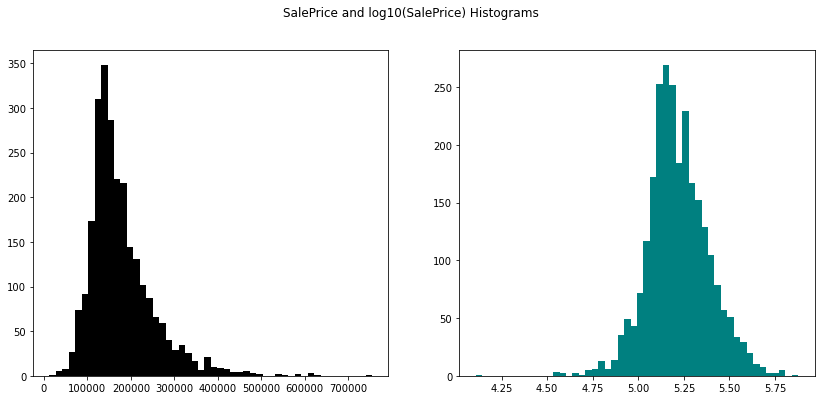

In [43]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

## <span style="color:darkred">Land-based</span> features ⛰️
* MSZoning / LotArea / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [44]:
landfeats = data[['MSZoning','LotArea','LotShape','LandContour','Utilities',
                  'LandSlope','Condition1','Condition2','Neighborhood','Sector']].copy()

**Numeric Features:** LotArea

In [45]:
landfeats.LotArea.describe()

count      2579.000000
mean      10119.269484
std        8128.389882
min        1300.000000
25%        7406.500000
50%        9382.000000
75%       11485.500000
max      215245.000000
Name: LotArea, dtype: float64

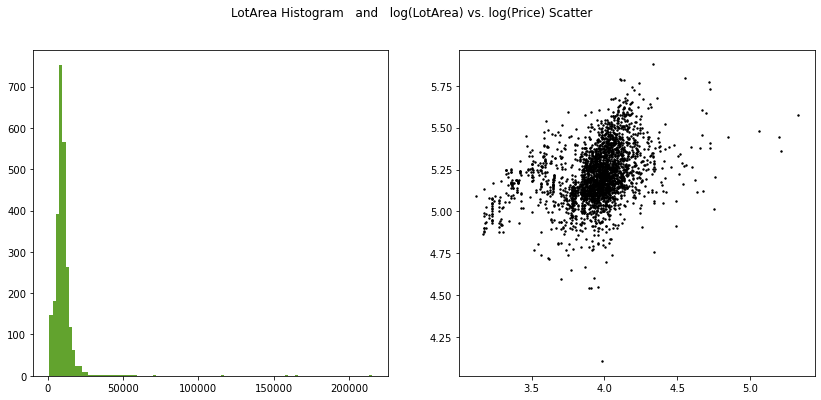

In [46]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LotArea Histogram   and   log(LotArea) vs. log(Price) Scatter')

ax1.hist(landfeats.LotArea, bins=100)
ax2.scatter(x=np.log10(landfeats.LotArea),y=np.log10(y),s=2,c='k')

**Categorical Features:** MSZoning / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [47]:
for col in landfeats.drop('LotArea', axis=1).columns:
    print(landfeats[col].value_counts())
    print('---------------------------')

RL         2007
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64
---------------------------
Reg    1640
IR1     855
IR2      71
IR3      13
Name: LotShape, dtype: int64
---------------------------
Lvl    2337
HLS      95
Bnk      95
Low      52
Name: LandContour, dtype: int64
---------------------------
AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64
---------------------------
Gtl    2458
Mod     108
Sev      13
Name: LandSlope, dtype: int64
---------------------------
Norm      2227
Feedr      137
Artery      81
RRAn        40
PosN        37
RRAe        26
PosA        19
RRNn         8
RRNe         4
Name: Condition1, dtype: int64
---------------------------
Norm      2554
Feedr       12
PosA         3
Artery       3
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
---------------------------
NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Som

In [48]:
land_all = y.to_frame().merge(landfeats, on='PID')

In [49]:
land_all['MSZoning'].value_counts().index

Index(['RL', 'RM', 'FV', 'RH', 'C (all)', 'I (all)', 'A (agr)'], dtype='object')

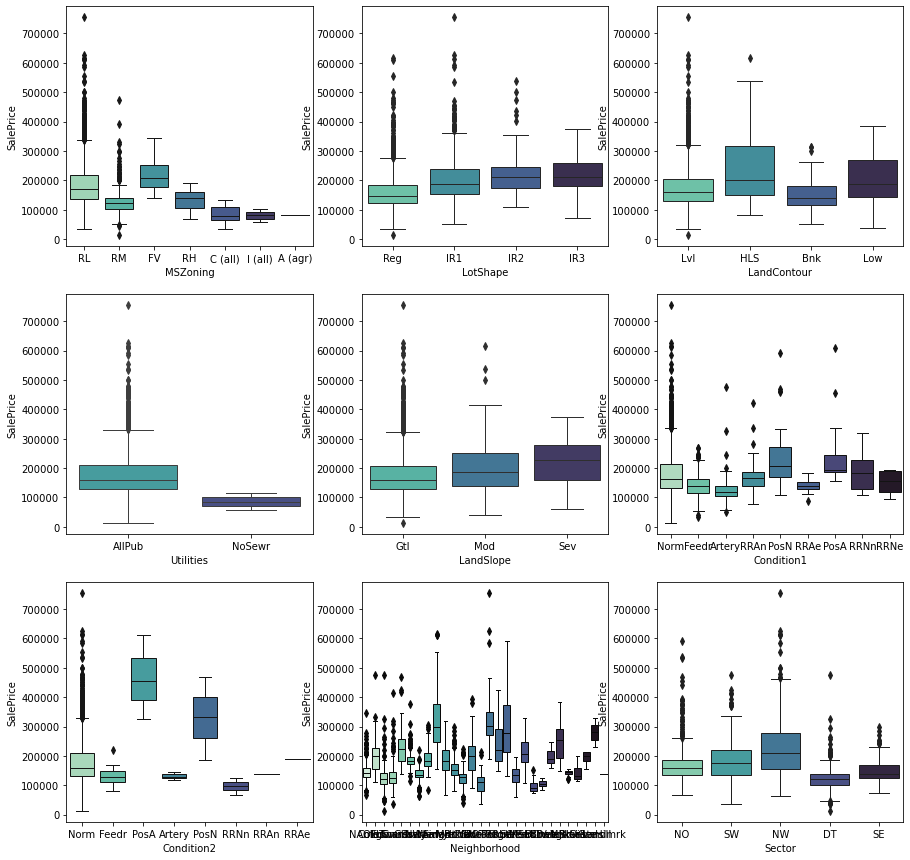

In [50]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for idx, COL in enumerate(landfeats.drop('LotArea', axis=1).columns):
    sns.boxplot(ax=ax[idx//3,idx%3],
            x=land_all[COL], y=land_all['SalePrice'], 
            order = land_all[COL].value_counts().index,
            palette="mako_r", linewidth=1)

### Findings
* LotShape and LandContour and LandSlope: may not be useful. Similar SalePrice, and concentrated in 1-2 categories
* Utilities: only 2 houses have 'No Sewer', rest are same
* Condition1 & Condition2: may be useful if a house is of PosN or PosA category, otherwise, not much use.

## <span style="color:darkred">General House</span> Features 📐
* MasVnrType, MasVnrArea, BldgType, HouseStyle, YearBuilt, YearRemodAdd, OverallQual, OverallCond

In [51]:
general = data[['MSSubClass','MasVnrType', 'MasVnrArea', 'BldgType', 
                'HouseStyle', 'YearBuilt', 'YearRemodAdd', 
                'OverallQual', 'OverallCond']]

In [52]:
general.head(3)

,MSSubClass,MasVnrType,MasVnrArea,BldgType,HouseStyle,YearBuilt,YearRemodAdd,OverallQual,OverallCond
PID,,,,,,,,,
526301100,20,Stone,112.0,1Fam,1Story,1960,1960,6,5
526302030,20,Stone,28.0,1Fam,1Story,1954,1954,6,5
526302040,20,BrkFace,244.0,1Fam,1Story,1956,1956,6,6


In [53]:
#Check Missing
general.isna().sum(axis=0)

MSSubClass       0
MasVnrType      14
MasVnrArea      14
BldgType         0
HouseStyle       0
YearBuilt        0
YearRemodAdd     0
OverallQual      0
OverallCond      0
dtype: int64

In [54]:
#Fill with "None" and 0
general = general.fillna({'MasVnrType':'None', 'MasVnrArea':0})
general.MasVnrType.isna().sum() + general.MasVnrArea.isna().sum()

0

In [55]:
np.round(general.MSSubClass.value_counts(normalize=True).sort_index()*100,2)

20     36.41
30      4.77
40      0.23
45      0.66
50     10.00
60     19.46
70      4.50
75      0.81
80      4.23
85      1.67
90      3.37
120     6.55
150     0.04
160     4.65
180     0.58
190     2.06
Name: MSSubClass, dtype: float64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

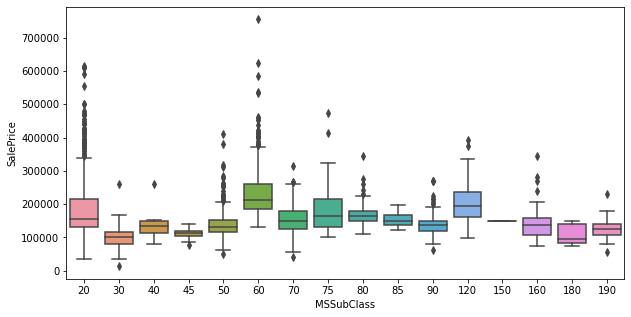

In [56]:
#Plot HouseClass
plt.figure(figsize=(10,5))
sns.boxplot(x=general.MSSubClass, y=y)

####  MSSubClass: Type of dwelling
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

#### Convert to:
    1Fl = 20,30,40,45,50
    2Fl = 60,70,75
    SPLIT = 80,85
    1FlPUD = 120,150
    2FlPUD = 160,180
    DUP2FM = 90,190

In [57]:
conv_dict = {}
for k in [20,30,40,45,50]:
    conv_dict[k] = '1Fl'
for k in [60,70,75]:
    conv_dict[k] = '2Fl'
for k in [80,85]:
    conv_dict[k] = 'SPLIT'
for k in [120,150]:
    conv_dict[k] = '1FlPUD'
for k in [160,180]:
    conv_dict[k] = '2FlPUD'
for k in [90,190]:
    conv_dict[k] = 'DUP2FAM'

    
general.loc[:,'MSSubClass'] = general.loc[:,'MSSubClass'].apply(lambda r: conv_dict[r])

In [58]:
general.MSSubClass.value_counts()

1Fl        1343
2Fl         639
1FlPUD      170
SPLIT       152
DUP2FAM     140
2FlPUD      135
Name: MSSubClass, dtype: int64

In [59]:
general = general.join(data[['Sector','Neighborhood','SalePrice','GrLivArea']],on='PID')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

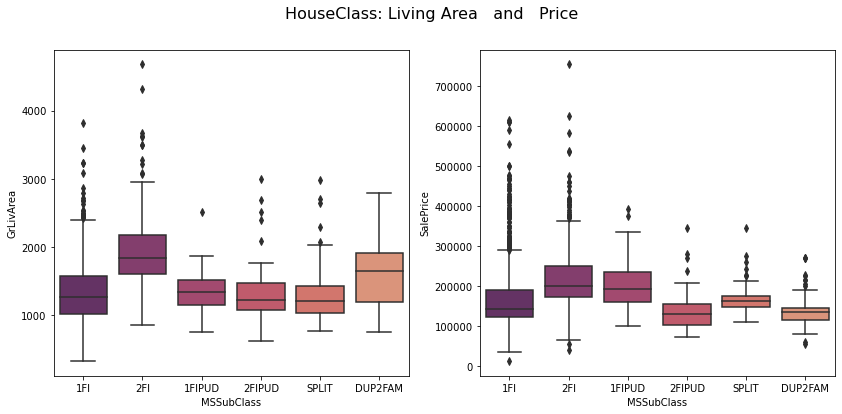

In [97]:
type_order=['1Fl','2Fl','1FlPUD','2FlPUD','SPLIT','DUP2FAM']
#Plot NEW HouseClass
sns.set_palette('flare_r')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('HouseClass: Living Area   and   Price', size=16)

sns.boxplot(ax=ax1,x=general.MSSubClass, y=general.GrLivArea, order=type_order)
sns.boxplot(ax=ax2,x=general.MSSubClass, y=general.SalePrice, order=type_order)

## <span style="color:red">Findings</span>: 2Fl PUD, Duplexes, and 2Fam conversions are priced low (esp. relative to their size)

In [98]:
# percentage of houseClass in each Sector of city
temp = general.groupby(['Sector'])['MSSubClass'].value_counts(normalize=True).to_frame()
temp.rename(columns={'MSSubClass':'HouseType'}, inplace=True)
temp.reset_index(inplace=True)
temp = temp.pivot(index='MSSubClass',columns='Sector', values='HouseType')
temp

Sector,DT,NO,NW,SE,SW
MSSubClass,,,,,
1Fl,0.666667,0.504414,0.413681,0.384058,0.583463
1FlPUD,NaN,0.073140,0.117264,0.072464,0.046802
2Fl,0.234097,0.234552,0.311075,0.079710,0.248050
2FlPUD,0.002545,0.055485,0.070033,0.217391,0.026521
DUP2FAM,0.089059,0.049180,0.035831,0.079710,0.051482
SPLIT,0.007634,0.083228,0.052117,0.166667,0.043682


Text(0, 0.5, 'Proportion')

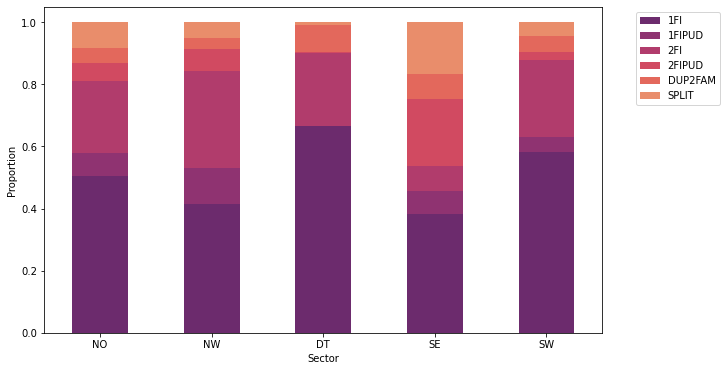

In [99]:
sec_order=['NO','NW','DT','SE','SW']
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, 
                           stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')

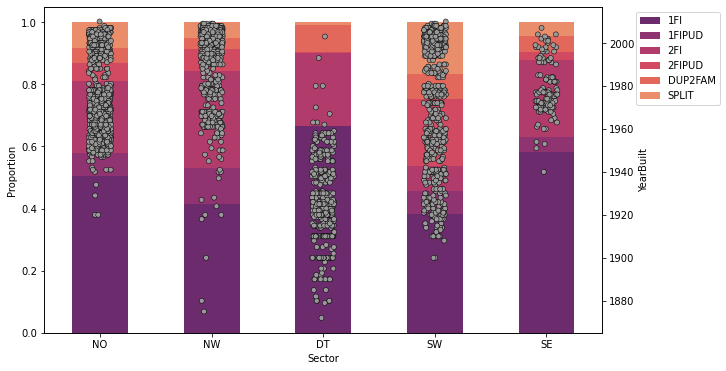

In [108]:
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, 
                             stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='YearBuilt', data=general, color='0.6', edgecolor='k', linewidth=0.5);

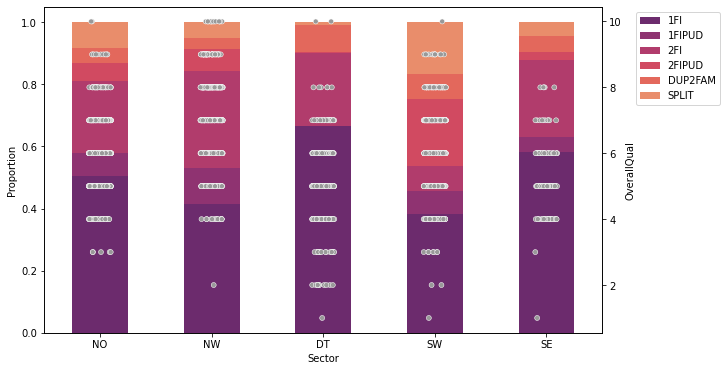

In [109]:
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, 
                             stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='OverallQual', data=general, color='0.6', edgecolor='w', linewidth=0.5);

## <span style="color:red">Findings</span>: DT House prices being low is mainly due to the AGE of the houses

### Price per SqFt <span style="color:teal">(Groupby Sector)</span>

In [110]:
pxperSF = {}
lm = LinearRegression()
for sector in general.Sector.unique():
    X = general.loc[general['Sector']==sector][['GrLivArea']]
    y = general.loc[general['Sector']==sector]['SalePrice']
    lm.fit(np.log10(X),np.log10(y))
        
    SF_range = np.arange(min(X.GrLivArea),max(X.GrLivArea),1)
    pxperSF[sector] = {n : 10**lm.intercept_*n**(lm.coef_-1)[0] for n in SF_range}
sector_pxperSF = pd.DataFrame(pxperSF)

### Price per SqFt <span style="color:teal">(Groupby HouseType)</span>

In [111]:
pxperSF = {}
lm = LinearRegression()
for housetype in general.MSSubClass.unique():
    X = general.loc[general['MSSubClass']==housetype][['GrLivArea']]
    y = general.loc[general['MSSubClass']==housetype]['SalePrice']
    lm.fit(np.log10(X),np.log10(y))
        
    SF_range = np.arange(min(X.GrLivArea),max(X.GrLivArea),1)
    pxperSF[housetype] = {n : 10**lm.intercept_*n**(lm.coef_-1)[0] for n in SF_range}
type_pxperSF = pd.DataFrame(pxperSF)

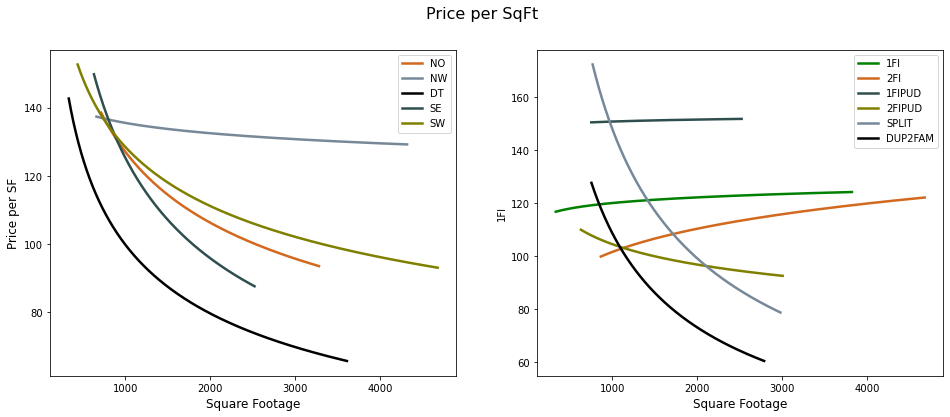

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Price per SqFt', size=16)

for sector, color in zip(sec_order,['#D2691E','#778899','k','#2F4F4F','#808000']):
    sns.lineplot(ax=ax1, x=sector_pxperSF.index, y=sector ,data=sector_pxperSF, 
                 color=color, label=sector, linewidth=2.5);
    ax1.set_ylabel('Price per SF', size=12)
    ax1.set_xlabel('Square Footage', size=12)
for housetype, color in zip(type_order,['g','#D2691E','#2F4F4F','#808000','#778899','k']):
    sns.lineplot(ax=ax2, x=type_pxperSF.index, y=housetype ,data=type_pxperSF, 
                 color=color, label=housetype, linewidth=2.5);
    ax2.set_xlabel('Square Footage', size=12)

### Trends in House Size and Year Built?

<AxesSubplot:xlabel='YearBuilt', ylabel='GrLivArea'>

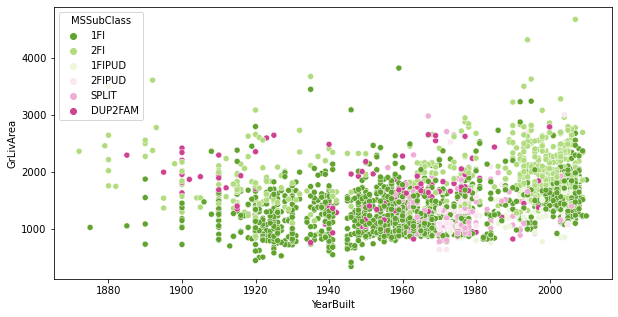

In [36]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='YearBuilt', y='GrLivArea', hue='MSSubClass', data=general, hue_order=type_order)

### Effect of remodeling?

<AxesSubplot:xlabel='Remodeled', ylabel='SalePrice'>

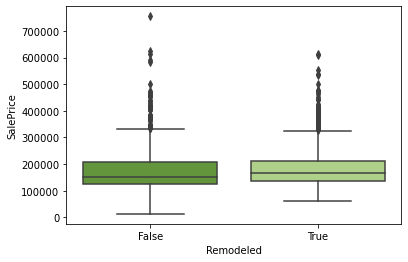

In [31]:
general['Remodeled'] = general.YearBuilt == general.YearRemodAdd
sns.boxplot(x=general.Remodeled, y=general.SalePrice)

### But why are SE houses cheap?

In [37]:
general[general.Sector=='SE']

,MSSubClass,MasVnrType,MasVnrArea,BldgType,HouseStyle,YearBuilt,YearRemodAdd,OverallQual,OverallCond,Sector,Neighborhood,SalePrice,GrLivArea,Remodeled
PID,,,,,,,,,,,,,,
913350030,1Fl,None,0.0,1Fam,1Story,1979,1979,6,6,SE,Mitchel,242500,1625,True
914452060,DUP2FAM,None,0.0,Duplex,1Story,1978,1978,6,5,SE,Mitchel,145000,1664,True
914452090,SPLIT,None,0.0,1Fam,SFoyer,1979,1979,6,6,SE,Mitchel,183500,1299,True
914452120,SPLIT,None,0.0,1Fam,SFoyer,1978,1978,6,6,SE,Mitchel,156000,912,True
914452190,1Fl,None,0.0,1Fam,1Story,1983,1983,6,5,SE,Mitchel,134000,1080,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924100060,2Fl,BrkFace,178.0,1Fam,2Story,1969,1969,5,7,SE,Mitchel,173000,1632,True
924100070,1Fl,None,0.0,1Fam,1Story,1974,1975,5,5,SE,Mitchel,170000,1389,False
924151040,1Fl,None,0.0,1Fam,1Story,1994,1995,8,5,SE,Mitchel,285000,1803,False


In [ ]:
#Check Categorical counts
for COL in general.drop(['MasVnrArea','YearBuilt','YearRemodAdd'],axis=1).columns:
    print(general[COL].value_counts())

Plot Numerical Features with SalePrice

In [ ]:
#Plot MasVnrArea
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MasVnr Area Histogram   and   MasVnr Area vs. log(Price) Scatter', size=16)

ax1.hist(general.MasVnrArea, bins=100)
ax2.scatter(x=general.MasVnrArea,y=np.log10(y),s=2,c='k')

In [ ]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   YearRemodeled vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.YearRemodAdd,y=np.log10(y),s=2,c='teal')

In [ ]:
lm = LinearRegression()
lm.fit(general[['YearBuilt','YearRemodAdd']],y)
lm.score(general[['YearBuilt','YearRemodAdd']],y)

In [ ]:
#Plot Quality and Condition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Overall Quality   and   Condition vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.OverallQual,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.OverallCond,y=np.log10(y),s=2,c='teal')

In [ ]:
lm = LinearRegression()
lm.fit(general[['OverallQual','OverallCond']],y)
lm.score(general[['OverallQual','OverallCond']],y)

In [ ]:
lm = LinearRegression()
lm.fit(general[['OverallQual']],y)
lm.score(general[['OverallQual']],y)

In [ ]:
# Plot MasVnrTYPE, BldgType, HouseStyle, 
fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, COL in enumerate(['MasVnrType', 'BldgType', 'HouseStyle']):
    sns.boxplot(ax=ax[idx],
            x=general[COL], y=y, 
            order = general[COL].value_counts().index,
            palette="mako_r", linewidth=1)

## <span style="color:darkred">Size Related</span> Features 📐
* Columns with "SF" / "AREA" / "Porch Size"

In [ ]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related.isnull().sum(axis=0)

In [ ]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

#### GrLivArea is just 1stFl + 2ndFl

In [ ]:
size_related.GrLivArea.head(20) == size_related['1stFlrSF'].head(20)+size_related['2ndFlrSF'].head(20)

### Create new Feature called <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [ ]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [ ]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

In [ ]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

### Investigate GrLivArea (largest correlation with Sale Price 0.72)

In [ ]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

In [ ]:
lm = LinearRegression()
lm.fit(np.log10(size_related[['GrLivArea']]),np.log10(y))
print(f"R2: {lm.score(np.log10(size_related[['GrLivArea']]),np.log10(y))}")
print(f'B1: {lm.coef_}')

#### Check Scatterplot for others

In [ ]:
size_related.columns

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

#### <span style="color:blue">1stFlr, Bsmt, 2ndFlr, Garage</span> might be useful

### Create new Feature called <span style="color:blue">LBratio</span> (Land to Building Ratio)
* LotArea / 1stFlrSF

In [ ]:
size_related['LBratio'] = size_related.LotArea/size_related['1stFlrSF']

In [ ]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LBratio vs Price Scatters')

ax1.scatter(x=size_related.LBratio,y=y,s=2,c='teal')
ax2.scatter(x=size_related.LBratio,y=np.log10(y),s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [ ]:
size_related.drop('LBratio',axis=1, inplace=True)

### Basement info not yet utilized, create feature called <span style="color:blue">BsmtFinRatio</span> (Ratio of Finished Basement)
* (TotalBsmtSF - BsmtUnfSF) / TotalBsmtSF

In [ ]:
size_related['BsmtFinRatio'] = (size_related.TotalBsmtSF - size_related.BsmtUnfSF)/size_related.TotalBsmtSF

In [ ]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('BsmtFinRatio vs Price Scatters')

ax1.scatter(x=size_related.BsmtFinRatio,y=y,s=2,c='teal')
ax2.scatter(x=np.log10(size_related.BsmtFinRatio),y=y,s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [ ]:
size_related.drop('BsmtFinRatio',axis=1, inplace=True)